In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# the following line is not required if Dataset is installed as a python package.
sys.path.append("../..")
from dataset import Dataset, DatasetIndex, R, P, V, C
from dataset.opensets import MNIST

In [2]:
BATCH_SIZE = 10

# Create a dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits frequently used as a baseline for machine learning tasks.

Let's download the data and create the dataset (it might take a few minutes to complete)

In [3]:
dataset = MNIST()

Extracting /tmp/train-images-idx3-ubyte.gz
ExtractingExtractingExtracting /tmp/t10k-images-idx3-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz
 /tmp/t10k-labels-idx1-ubyte.gz


MNIST dataset will create instances of [ImagesBatch](https://analysiscenter.github.io/dataset/intro/images_batch.html).

You can also use [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html):

    from dataset.opensets import CIFAR10
    
    dataset = CIFAR10()

It takes much more time to download, though.

For CIFAR examples see [the image augmentation tutorial](./04_image_augmentation_examples.ipynb).

Let's get a batch and look at the dataset content.

In [4]:
def show_images(batch):
    img = np.concatenate(batch.images, axis=1).reshape(-1, batch.images.shape[1] * len(batch))
    fig, ax = plt.subplots(1, figsize=(10, 4))
    ax.axis('off')
    ax.imshow(img, cmap="gray")
    plt.show()

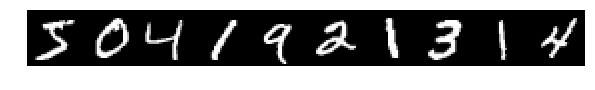

In [5]:
batch = dataset.train.next_batch(BATCH_SIZE)
show_images(batch)

Execute the cell above several time to see different batches.

# Define a pipeline

A pipeline represents a sequence of actions applied to a dataset.

These actions might come from [Pipeline API](https://analysiscenter.github.io/dataset/intro/pipeline.html) or a batch class action-methods (e.g. [ImagesBatch](https://analysiscenter.github.io/dataset/intro/images_batch.html))

Just write them one after another.

In [6]:
simple_pipeline = (dataset.train.p
                     .scale(p=.5, factor=1.5, preserve_shape=True)
                     .rotate(p=.5, angle=60, reshape=False)
                     .salt(p=.5, color=255, p_noise=.05)
                     .elastic_transform(p=.5, alpha=20, sigma=1.8)
)

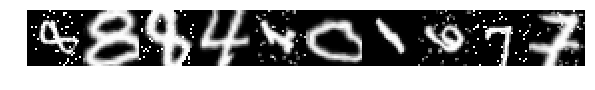

In [7]:
batch = simple_pipeline.next_batch(BATCH_SIZE)
show_images(batch)

Read [the documentation](https://analysiscenter.github.io/dataset/intro/pipeline.html) for advanced pipeline techniques.

# Use pipeline variables

In [8]:
simple_pipeline = (dataset.train.p
                     .init_variable('angle', 60)
                     .init_variable('factor', 1.5)
                     .init_variable('salt_color', 255)
                     .init_variable('proba', .5)
                     .scale(p=V('proba'), factor=V('factor'), preserve_shape=True)
                     .rotate(p=V('proba'), angle=V('angle'), reshape=False)
                     .salt(p=V('proba'), color=V('salt_color'), p_noise=.05)
                     .elastic_transform(p=V('proba'), alpha=20, sigma=1.8)
)

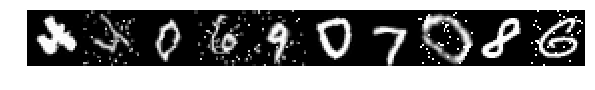

In [9]:
batch = simple_pipeline.next_batch(BATCH_SIZE)
show_images(batch)

Read [more about variables and how to use them](https://analysiscenter.github.io/dataset/intro/pipeline.html#pipeline-variables).

# Pipeline configuration

Same result can be achieved with a pipeline config.

In [10]:
config = dict(angle=60, factor=1.5, salt_color=255, proba=.5)

simple_pipeline = (dataset.train.pipeline(config)
                     .scale(p=C('proba'), factor=C('factor'), preserve_shape=True)
                     .rotate(p=C('proba'), angle=C('angle'), reshape=False)
                     .salt(p=C('proba'), color=C('salt_color'), p_noise=.05)
                     .elastic_transform(p=C('proba'), alpha=20, sigma=1.8)
)

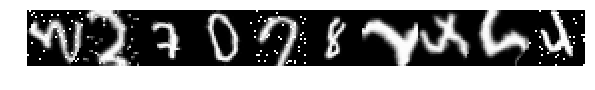

In [11]:
batch = simple_pipeline.next_batch(BATCH_SIZE)
show_images(batch)

# Sampling random values

Sometimes you might want random values instead of hard-coded constants.

`R` and `P` [named expressions](https://analysiscenter.github.io/dataset/intro/named_expr.html) might come in handy here.

In [12]:
config = dict(angle=R('uniform', -45, 45), factor=P(R('normal', 1.5, .2)), salt_color=255, proba=.5)

simple_pipeline = (dataset.train.pipeline(config)
                     .scale(p=C('proba'), factor=C('factor'), preserve_shape=True)
                     .rotate(p=C('proba'), angle=C('angle'), reshape=False)
                     .salt(p=C('proba'), color=C('salt_color'), p_noise=.05)
                     .elastic_transform(p=C('proba'), alpha=20, sigma=1.8)
)

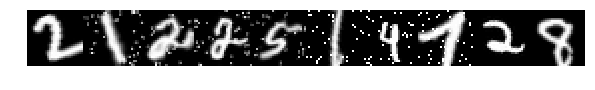

In [13]:
batch = simple_pipeline.next_batch(BATCH_SIZE)
show_images(batch)

The difference between `R(...)` and `P(R(...))` is that the former gives a single random value for **all** batch items, while the latter gives a random value for **each** batch item.

# Running pipelines

See [the documentation](https://analysiscenter.github.io/dataset/intro/pipeline.html#running-pipelines) for a the detailed description.

## next_batch

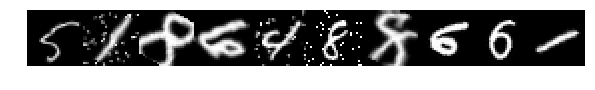

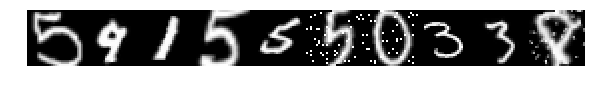

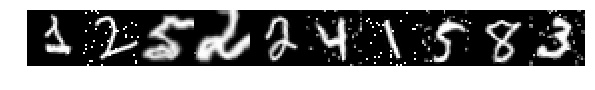

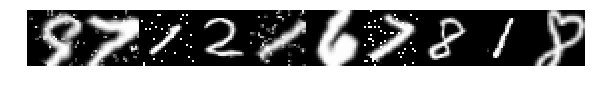

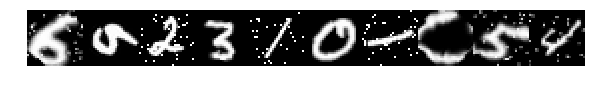

In [14]:
for i in range(5):
    batch = simple_pipeline.next_batch(BATCH_SIZE, n_epochs=1)
    show_images(batch)

See [dataset tutorial](./01_dataset_basic_operations.ipynb) for more info about `next_batch` / `gen_batch` and their parameters (`shuffle`, `drop_last`, `n_epochs`, etc)

### gen_batch

While `next_batch` is an ordinary function returning processed batches, `gen_batch` is a generator

In [ ]:
for batch in simple_pipeline.gen_batch(BATCH_SIZE, n_epochs=1):
    # do whatever you want
    pass
# Executing this cell might take a lot of time, depending on your hardware, pipeline content and the dataset size.

## run

A concise form of `for batch in pipeline.gen_batch(...)`

In [16]:
simple_pipeline.run(BATCH_SIZE, n_epochs=1, shuffle=True, drop_last=True, bar=True)

100%|█████████▉| 5999/6000 [04:35<00:00, 13.28it/s]

100%|██████████| 6000/6000 [04:50<00:00, 13.28it/s]

There is also a [prefetch](https://analysiscenter.github.io/dataset/intro/prefetch.html) option for a faster execution and a [bar](https://analysiscenter.github.io/dataset/intro/pipeline.html#running-pipelines) option to show progress.